In [1]:
%matplotlib inline

# Essentials: Data Cleansing and ETL
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.legend_handler import HandlerLine2D

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc # good for evaluation of binary classification problems
from sklearn.model_selection import train_test_split




In [2]:
df = pd.read_csv('C:/Esteban/NYU/Fall2018/1007ProgForDataScience/Proyecto/NFL2009-2017v4.csv', low_memory=False)

In [3]:
pass_avg = df[(df.PlayType == 'Pass')|(df.PlayType == 'Sack')]
run_avg = df[(df.PlayType == 'Run')]

In [4]:
pass_avg = pass_avg.groupby(['GameID','posteam'])['Yards.Gained'].expanding().mean()
pass_avg = pass_avg.groupby(['GameID','posteam']).transform(lambda x:x.shift()).reset_index()
# pass_avg = pd.DataFrame(pass_avg.groupby(['GameID','posteam'])['Yards.Gained'].expanding().mean().shift(1)).reset_index()
pass_avg['index'] = pass_avg['level_2'].apply(lambda x: int(x))
pass_avg = pass_avg.drop(['GameID','posteam','level_2'], axis =1)
pass_avg = pass_avg.rename(index=str, columns={"Yards.Gained": "pass_avg"})
pass_avg = pass_avg.set_index('index')

run_avg = run_avg.groupby(['GameID','posteam'])['Yards.Gained'].expanding().mean()
run_avg = run_avg.groupby(['GameID','posteam']).transform(lambda x:x.shift()).reset_index()
# run_avg = pd.DataFrame(run_avg.groupby(['GameID','posteam'])['Yards.Gained'].expanding().mean().shift(1)).reset_index()
run_avg['index'] = run_avg['level_2'].apply(lambda x: int(x))
run_avg = run_avg.drop(['GameID','posteam','level_2'], axis =1)
run_avg = run_avg.rename(index=str, columns={"Yards.Gained": "run_avg"})
run_avg = run_avg.set_index('index')

In [5]:
df = pd.concat([df, pass_avg], axis=1)
df = pd.concat([df, run_avg], axis=1)

In [6]:
df['run_avg2'] = df.groupby(['posteam','GameID'])['run_avg'].fillna(method='ffill')
df['pass_avg2'] = df.groupby(['posteam','GameID'])['pass_avg'].fillna(method='ffill')
df = df.drop('run_avg',axis =1)
df = df.drop('pass_avg',axis =1)

In [7]:
df['Pass_or_Sack_yds'] = df.PlayType.apply(lambda x: 1 if x == 'Pass' else (1 if x == 'Sack' else None))
df['Pass_or_Sack_yds'] = df['Pass_or_Sack_yds']*df['Yards.Gained']
df['Run_yds'] = df.PlayType.apply(lambda x: 1 if x == 'Run' else None)
df['Run_yds'] = df['Run_yds']*df['Yards.Gained']

In [8]:
#Gives season & quarter pass/run averages for each team. 
#Doesn't work on first game of season, those will still have NaN.
#Also it is an 8-game moving average like Ziv did before.
quaterly_averages = df.groupby(['GameID','posteam','Season','qtr'])['Pass_or_Sack_yds','Run_yds'].mean().reset_index()
quaterly_averages['PassingWA']=quaterly_averages.groupby(['posteam','qtr','Season']).Pass_or_Sack_yds.apply(lambda x: x.shift().rolling(8,min_periods=1).mean())
quaterly_averages['RushingWA']=quaterly_averages.groupby(['posteam','qtr','Season']).Run_yds.apply(lambda x: x.shift().rolling(8,min_periods=1).mean())
quaterly_averages['GameID'] = quaterly_averages['GameID'].apply(lambda x:str(x))
quaterly_averages['qtr'] = quaterly_averages['qtr'].apply(lambda x:str(x))
quaterly_averages['key'] = quaterly_averages['GameID'] + quaterly_averages['posteam'] + quaterly_averages['qtr']
quaterly_averages = quaterly_averages.drop(columns=['Pass_or_Sack_yds','Run_yds','GameID','Season','posteam','qtr'])

In [9]:
#using a key to merge on multiple conditions. No idea if there is an easier way to do this.
df['key'] = df['GameID'].apply(lambda x: str(x)) + df['posteam'] + df['qtr'].apply(lambda x: str(x))
df = df.merge(quaterly_averages, left_on = 'key', right_on = 'key', how = 'outer')
df = df.drop('key', axis = 1)

In [10]:
#filling NaN with quartly value from previous games
df.run_avg2.fillna(df.RushingWA, inplace=True)
df.pass_avg2.fillna(df.PassingWA, inplace=True)

In [11]:
# We could also try running with just the quarterly averages. 
#We will have to drop all the first games of the season though.
#I'm leaving those columns in. They are "PassingWA" and "RushingWA".
df = df.drop(['Pass_or_Sack_yds', 'Run_yds','PassingWA','RushingWA'], axis = 1)

In [13]:
df3 = df[df['down']==3]

In [14]:
df3 = df3[['TimeSecs','yrdline100','ydstogo','GoalToGo','PlayType','ScoreDiff',
         'posteam_timeouts_pre','Field_Goal_Prob','Safety_Prob','Touchdown_Prob','TimeUnder','qtr','run_avg2','pass_avg2']]

In [15]:
df3['2Min'] = (df3['TimeUnder'] < 3) & ((df3['qtr']== 2) | (df3['qtr']== 4))

In [16]:
df3['2Min'].replace(to_replace=[True,False],value=[1,0],inplace=True)

In [17]:
df3.drop(['qtr','TimeUnder'],inplace=True,axis=1)

In [18]:
df3

,TimeSecs,yrdline100,ydstogo,GoalToGo,PlayType,ScoreDiff,posteam_timeouts_pre,Field_Goal_Prob,Safety_Prob,Touchdown_Prob,run_avg2,pass_avg2,2Min
3,3515.0,56.0,8,0.0,Pass,0.0,3,0.289336,0.004776,0.318621,NaN,5.000000,0
9,3241.0,22.0,2,0.0,Sack,0.0,3,0.464748,0.002827,0.422665,-3.000000,5.400000,0
13,3027.0,70.0,7,0.0,Sack,0.0,3,0.199168,0.004316,0.284916,-1.000000,1.333333,0
17,2712.0,76.0,7,0.0,Pass,0.0,3,0.162083,0.003949,0.256666,0.200000,-0.142857,0
20,3431.0,94.0,6,0.0,Run,0.0,3,0.086777,0.003299,0.184451,0.000000,NaN,0
26,3112.0,19.0,7,0.0,Pass,0.0,3,0.533660,0.003571,0.346176,10.000000,8.000000,0
32,2886.0,57.0,3,0.0,Pass,0.0,3,0.265274,0.003746,0.380473,8.250000,7.166667,0
25031,2624.0,34.0,12,0.0,Sack,0.0,3,0.446245,0.004404,0.325937,6.166667,6.090909,0
25035,2191.0,69.0,6,0.0,Pass,0.0,3,0.154232,0.003018,0.230646,5.000000,4.384615,0
25041,2041.0,40.0,7,0.0,Pass,0.0,3,0.297173,0.003004,0.274870,4.666667,5.000000,0


In [22]:
df3.run_avg2.isna().sum()

149

In [23]:
df3.pass_avg2.isna().sum()

85

In [24]:
df3.dropna(inplace=True) #Noplays are all kinds of penalties, hard to deal for (for now). Will remove.

In [25]:
TypeList = ['Pass','Run','Sack']
dfthird = df3[df3['PlayType'].isin(TypeList)].copy()
dfthird.replace(to_replace=['Pass','Sack','Run'],value=[1,1,0],inplace=True)

In [26]:
dfthird.PlayType.value_counts()

1    48269
0    12596
Name: PlayType, dtype: int64

In [27]:
X = dfthird.drop('PlayType',axis=1)
y = dfthird['PlayType']

In [28]:
from sklearn import model_selection
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.20, random_state = 69)

In [29]:
dtc = DecisionTreeClassifier()
dtc.fit(train_X, train_y)

dt_predictions = dtc.predict(val_X)

false_positive_rate, true_positive_rate, thresholds = roc_curve(val_y, dt_predictions)
dt_roc_auc = auc(false_positive_rate, true_positive_rate)

In [30]:
rf = RandomForestClassifier(random_state = 69)
rf.fit(train_X, train_y)

rf_predictions = rf.predict(val_X)

false_positive_rate, true_positive_rate, thresholds = roc_curve(val_y, rf_predictions)
rf_roc_auc = auc(false_positive_rate, true_positive_rate)


In [31]:
log_reg = LogisticRegression(penalty='l1')
log_reg.fit(train_X, train_y)

lr_predictions = log_reg.predict(val_X)

false_positive_rate, true_positive_rate, thresholds = roc_curve(val_y, lr_predictions)
lr_roc_auc = auc(false_positive_rate, true_positive_rate)

In [32]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(train_X, train_y)

knn_predictions = knn.predict(val_X)

false_positive_rate, true_positive_rate, thresholds = roc_curve(val_y, knn_predictions)
knn_roc_auc = auc(false_positive_rate, true_positive_rate)

In [33]:
gnb = GaussianNB()
gnb.fit(train_X, train_y)

gnb_predictions = gnb.predict(val_X)

false_positive_rate, true_positive_rate, thresholds = roc_curve(val_y, gnb_predictions)
gnb_roc_auc = auc(false_positive_rate, true_positive_rate)

In [34]:
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Logistic Regression', 'KNN',
              'Naive Bayes'],
    'AUC': [dt_roc_auc, rf_roc_auc, lr_roc_auc, knn_roc_auc, gnb_roc_auc]})
result_df = results.sort_values(by='AUC', ascending=False)
result_df = result_df.set_index('AUC')
result_df.head(7)

,Model
AUC,
0.707630,Random Forest
0.651778,Decision Tree
0.626160,Logistic Regression
0.574494,KNN
0.551344,Naive Bayes


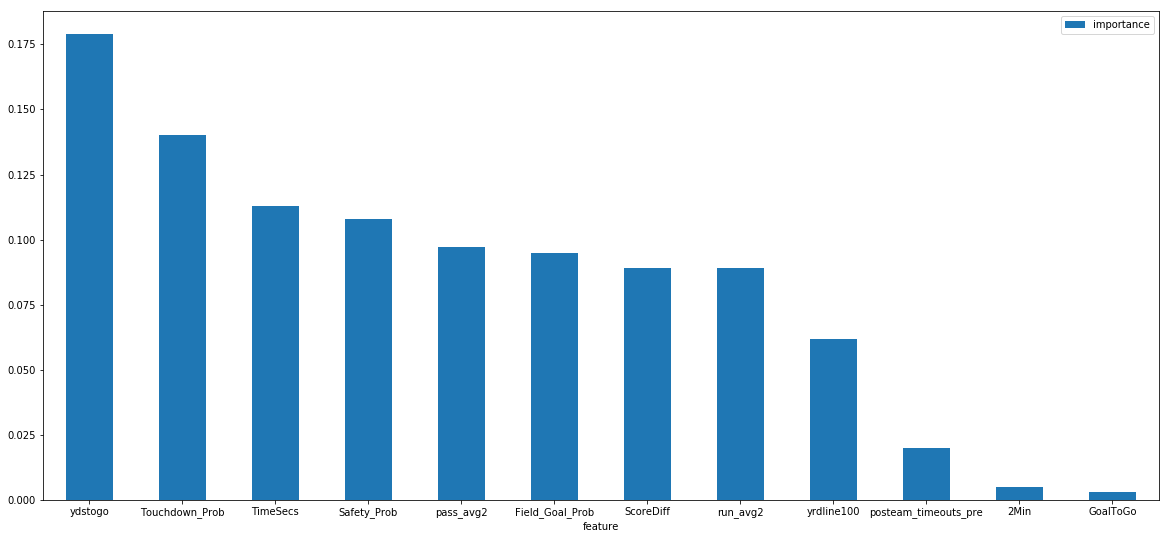

In [35]:
importances = pd.DataFrame({'feature':train_X.columns,'importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize=(20,9), rot=0)

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 27)

model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7176478341037548

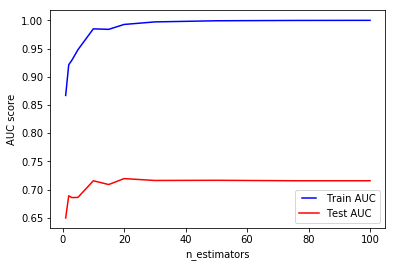

In [37]:
n_estimators = [1, 2, 3, 5, 10, 15, 20, 30, 50, 75, 100]

train_results = []
test_results = []
for estimator in n_estimators:
    model = RandomForestClassifier(n_estimators=estimator)
    model.fit(x_train, y_train)

    train_pred = model.predict(x_train)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(x_test)


    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

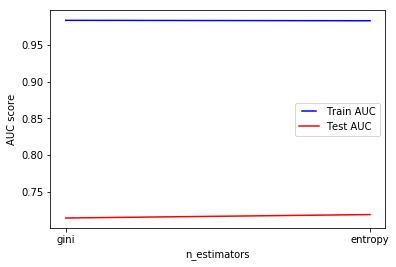

In [38]:
criterions = ['gini', 'entropy']

train_results = []
test_results = []
for crit in criterions:
    model = RandomForestClassifier(criterion=crit)
    model.fit(x_train, y_train)

    train_pred = model.predict(x_train)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(x_test)


    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(criterions, train_results, 'b', label="Train AUC")
line2, = plt.plot(criterions, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

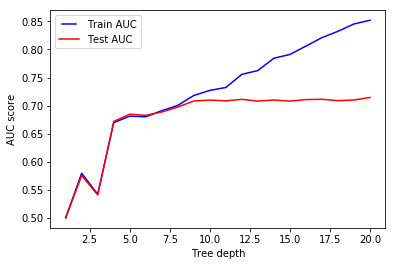

In [39]:
max_depths = np.linspace(1, 20, 20, endpoint=True)

train_results = []
test_results = []
for max_depth in max_depths:
    model = RandomForestClassifier(max_depth=max_depth)
    model.fit(x_train, y_train)

    train_pred = model.predict(x_train)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(x_test)


    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

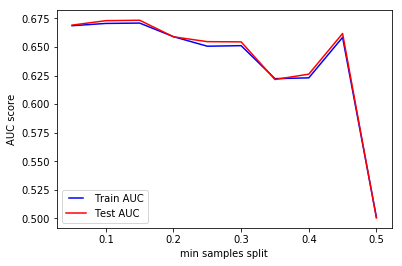

In [40]:
min_samples_splits = np.linspace(0.05, .5, 10, endpoint=True)

train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    model = RandomForestClassifier(min_samples_split=min_samples_split)
    model.fit(x_train, y_train)

    train_pred = model.predict(x_train)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(x_test)


    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

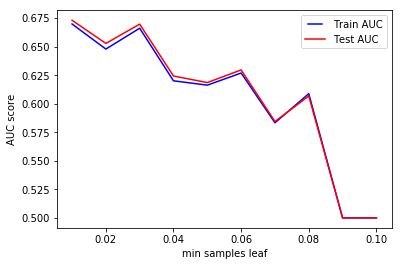

In [41]:
min_samples_leafs = np.linspace(0.01, 0.1, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    model = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
    model.fit(x_train, y_train)

    train_pred = model.predict(x_train)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(x_test)


    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

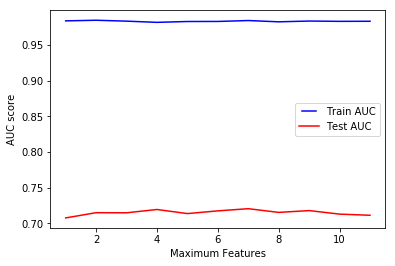

In [42]:
max_features = list(range(1,X.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    model = RandomForestClassifier(max_features=max_feature)
    model.fit(x_train, y_train)

    train_pred = model.predict(x_train)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(x_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('Maximum Features')
plt.show()

In [47]:
model = RandomForestClassifier(criterion='entropy',random_state = 69)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=69, verbose=0, warm_start=False)

In [48]:
y_pred = model.predict(x_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7218979006542311

In [49]:
from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred)

array([[1314, 1238],
       [ 684, 8937]], dtype=int64)